In [1]:
import pandas as pd
import importlib
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from fears.population import Population
from fears.utils import plotter
from matplotlib import colors
from spatialentropy import altieri_entropy
from datetime import date
import time
import sys
from fears.population import Population
sys.path.append("./utils")
from DoseResponseModel import DoseResponseModel
import seaborn as sns

In [2]:
p = Population(death_model = None,n_allele=2,fitness_data='random')
p.drugless_rates = [1.28949852, 1.14399848, 1.22802236, 0.93619847]
p.ic50 = [-0.49205992, 1.76224515,  1.39341393,  2.84653598]

def get_most_fit_at_conc_1d(data):
    most_fit_at_conc = np.zeros(data.shape)
    for z in range(data.shape[0]):
        # conc = 10**data[z,j]
        conc = data[z]
        p_fit_list = p.gen_fit_land(conc)
        most_fit_at_conc[z] = int((np.argmax(p_fit_list)))
    return most_fit_at_conc

def get_most_fit_at_conc(data):
    most_fit_at_conc = np.zeros(data.shape)
    for z in range(data.shape[0]):
        for j in range(data.shape[1]):
            # conc = 10**data[z,j]
            conc = data[z,j]
            p_fit_list = p.gen_fit_land(conc)
            most_fit_at_conc[z,j] = int((np.argmax(p_fit_list)))
    return most_fit_at_conc

def estimate_corr(data_folder,consumpt_rate,n_replicates,debug=False):
    msw_entropy = []
    pop_entropy = []
    msw_count = []
    pop_count = []
    # consumpt_rate_list = []
    for i,rate in enumerate(consumpt_rate):
        dataDir = data_folder + "/cellCountDoseResponse_{}".format(i)
        diffGridFile = dataDir + '/RepId_0_diffGrid.csv'
        diffGrid = pd.read_csv(diffGridFile)
        msw_list = get_most_fit_at_conc_1d(np.array(diffGrid['field']))
        msw_list = np.array(msw_list, dtype=int)
        points = np.array(diffGrid[['x','y']])
        e_msw = altieri_entropy(points, msw_list)
        
        for j in range(n_replicates):
            dataDir = data_folder + "/cellCountDoseResponse_{}".format(i)
            popGridFile = dataDir + '/RepId_{}_popGrid.csv'.format(j)
            popGrid = pd.read_csv(popGridFile)
            points = np.array(popGrid[['x','y']])
            types = np.array(popGrid['genotype'])
            if len(types) == 0:
                e_pop = 0
                pop_entropy.append(e_pop)
            else:
                e_pop = altieri_entropy(points, types)
                pop_entropy.append(e_pop.entropy)
            msw_entropy.append(e_msw.entropy)
            # consumpt_rate_list.append(rate)
            for g in range(4):
                msw_count.append(np.sum(msw_list==g))
                pop_count.append(np.sum(types==g))

            if debug and j == 0:
                # plot exemplary sims
                fig,ax_list = plt.subplots(ncols=2,figsize=(10,5))
                msw_img = np.zeros((100,100))
                pop_img = np.zeros((100,100))
                for index,row in popGrid.iterrows():
                    x,y = row['x'],row['y']
                    pop_img[int(row['x']),int(row['y'])] = row['genotype']
                for index,row in diffGrid.iterrows():
                    if row['field'] > 0:
                        msw_img[int(row['x']),int(row['y'])] = row['field']
                msw_img = get_most_fit_at_conc(msw_img)
                cc = plotter.gen_color_cycler(style='solid',n_colors=4,palette='colorblind')
                cc_dict = cc.by_key()
                c = cc_dict['color']

                indx = list(set(msw_img.flatten()))
                indx = [int(i) for i in indx]
                c = [c[i] for i in indx]

                cmap = colors.ListedColormap(c)
                ax_list[0].imshow(msw_img,cmap=cmap)
                ax_list[1].imshow(pop_img,cmap=cmap)

    # compute correlation
    msw_entropy = np.array(msw_entropy)
    pop_entropy = np.array(pop_entropy)
    msw_count = np.array(msw_count)
    pop_count = np.array(pop_count)
    # entropy_res = stats.linregress(msw_entropy,pop_entropy)
    square_deviation = np.sum((msw_entropy-pop_entropy)**2)/np.sum(msw_entropy)
    nonzero_indx = np.logical_and(msw_count>0,pop_count>0)
    # area_res = stats.linregress(np.log(msw_count[nonzero_indx]),np.log(pop_count[nonzero_indx]))
    # return entropy_res, area_res
    if debug:
        fig,ax_list = plt.subplots(ncols=2)
        ax = ax_list[0]
        ax.scatter(np.log(msw_count[nonzero_indx]),np.log(pop_count[nonzero_indx]))
        # ax.plot(np.log(msw_count[nonzero_indx]),area_res.slope*np.log(msw_count[nonzero_indx])+area_res.intercept)
        ax.set_xlabel('log(MSW count)')
        ax.set_ylabel('log(Population count)')
        ax = ax_list[1]
        ax.scatter(msw_entropy,pop_entropy)
        # ax.plot(msw_entropy,entropy_res.slope*msw_entropy+entropy_res.intercept)
        ax.set_xlabel('MSW entropy')
        ax.set_ylabel('Population entropy')
        fig.tight_layout()
    # return area_res, square_deviation
    return square_deviation

In [3]:
# setup parameter sweep
mutation_rates = np.logspace(-4, 0, 5)

init_mutant = np.logspace(-5, -1, 5)
init_mutant = np.append(0,init_mutant)

consumpt_rate = [0.001,0.01]

n_replicates = 1

jarFileName = "./HAL_dose_response.jar"
imgDir = "./tmp/"
today = date.today()
date_str = today.strftime("%Y-%m-%d")
data_folder = "./data/sensitivity_analysis_" + date_str

modelConfigDic = {'xDim':100,"yDim":100,'nTSteps':5000,"saveModelState":True,
                    "imageFrequency":-1,"consumpRate":None,
                    "nReplicates":n_replicates,"dt":0.1,"initialGeometry":"circle","initialDensity":0.01,
                    "saveFinalDiffImg":True,"saveFinalDiffGrid":True,"saveFinalPopGrid":True,
                "mutProb":0.001,"dieProb":0.1,"threeParamHill":True}

total_sims = len(mutation_rates)*len(init_mutant)*len(consumpt_rate)*n_replicates
sim_count = 0

entropy_res_dict = {}
# area_res_dict = {}

for r_m in mutation_rates:
    for i_m in init_mutant:
        indx = 0
        # st = time.time()
        for cr in consumpt_rate:
            modelConfigDic['consumpRate'] = cr
            modelConfigDic['pMutant'] = i_m
            modelConfigDic['mutProb'] = r_m
            dataDir = data_folder + "/cellCountDoseResponse_{}".format(indx)
            myModel = DoseResponseModel(jarFileName = jarFileName, outDir=dataDir, imageOutDir=imgDir, **modelConfigDic)
            myModel.Simulate()
            indx += 1
            sim_count += 1

        er = estimate_corr(data_folder,consumpt_rate,n_replicates,debug=False)
        # print('\n')
        # res_dict[(r_m,i_m)] = ar
        entropy_res_dict[(r_m,i_m)] = er
        # area_res_dict[(r_m,i_m)] = ar
        # print('Mutation rate: {}'.format(r_m))
        # print('Initial mutant: {}'.format(i_m))
        # print(er)
        # print(ar)
        # elapsed = time.time() - st
        # time_remaining = (total_sims - sim_count)*elapsed
        # print('\n')
        # print("Estimated time remaining: {} seconds".format(np.round(time_remaining)))

        

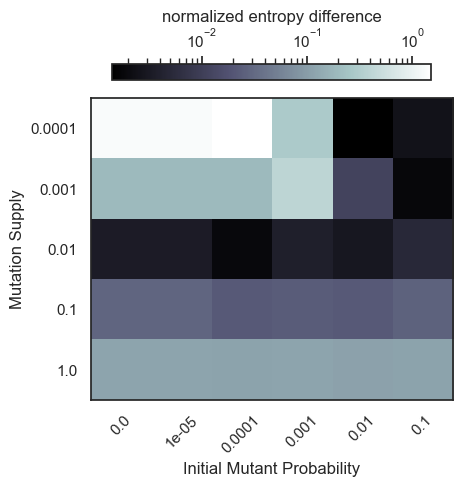

In [4]:
# slope_mat = np.zeros((len(mutation_rates),len(init_mutant)))
# p_mat = np.zeros((len(mutation_rates),len(init_mutant)))
entropy_map = np.zeros((len(mutation_rates),len(init_mutant)))
# for i in range(len(mutation_rates)):
#     for j in range(len(init_mutant)):
#         r_mat[i,j] = res_dict[(mutation_rates[i],init_mutant[j])].rvalue
#         p_mat[i,j] = res_dict[(mutation_rates[i],init_mutant[j])].pvalue
for key in entropy_res_dict.keys():
    mut_indx = np.argwhere(np.array(mutation_rates) == key[0])[0][0]
    init_indx = np.argwhere(np.array(init_mutant) == key[1])[0][0]
    entropy_map[mut_indx,init_indx] = entropy_res_dict[key]
    # p_mat[mut_indx,init_indx] = entropy_res_dict[key]

# fig,ax_list = plt.subplots(ncols=2,figsize=(9,5))

# ax = ax_list[0]

# slope_mat_log = np.log10(slope_mat)

fig,ax = plt.subplots(figsize=(6,5))

# im0 = ax.imshow(slope_mat_log,cmap='viridis_r')

# ax =  ax_list[1]
norm = colors.LogNorm(vmin=entropy_map.min(), vmax=entropy_map.max())
im = ax.imshow(entropy_map,cmap='bone',norm=norm)
# im1 = ax_list[1].imshow(p_mat)
# for ax in ax_list:
ax.set_xticks(np.arange(len(init_mutant)))
ax.set_xticklabels(init_mutant,rotation=45)
ax.set_yticks(np.arange(len(mutation_rates)))
# mutation_supply = np.array(mutation_rates)*10**4
ax.set_yticklabels(mutation_rates)
ax.set_xlabel('Initial Mutant Probability')
ax.set_ylabel('Mutation Supply')

# make colorbars
fig.colorbar(im,ax=ax,shrink=0.6,label='normalized entropy difference',location='top')
# fig.colorbar(im1,ax=ax_list[1],shrink=0.7,label='normalized error',location='top')
# fig.colorbar(im1,ax=ax_list[1],shrink=0.5)

fig.tight_layout()
fig.savefig('figures/sensitivity_analysis.png',dpi=300)
mut_rate_vs_init_mut_data = entropy_map


# Sensitivity analysis: blood vessel distance and initial mutant proportion

In [5]:
init_mutant = np.logspace(-5, -1, 5)
# init_mutant = np.array([0.1])
init_mutant = np.append(0,init_mutant)

# consumpt_rate = [10**-4,0.001,0.01,0.1]
consumpt_rate = [0.001,0.01]
# vessel_sep = [30,40,50,60,70]
vessel_sep = [0,20,40,60,80]

n_replicates = 3

jarFileName = "./HAL_dose_response.jar"
imgDir = "./tmp/"
today = date.today()
date_str = today.strftime("%Y-%m-%d")
data_folder = "./data/sensitivity_analysis_" + date_str

# modelConfigDic = {'xDim':100,"yDim":100,'nTSteps':5000,"saveModelState":True,
#                     "imageFrequency":-1,"consumpRate":None,
#                     "nReplicates":n_replicates,"dt":0.1,"initialGeometry":"square","initialDensity":0.01,
#                     "saveFinalDiffImg":True,"saveFinalDiffGrid":True,"saveFinalPopGrid":True,
#                     "vesselSep":50,"mutProb":0.001}

modelConfigDic = {'xDim':100,"yDim":100,'nTSteps':5000,"saveModelState":True,
                    "imageFrequency":-1,"consumpRate":None,
                    "nReplicates":n_replicates,"dt":0.1,"initialGeometry":"circle","initialDensity":0.01,
                    "saveFinalDiffImg":True,"saveFinalDiffGrid":True,"saveFinalPopGrid":True,
                "mutProb":0.001,"dieProb":0.1,"threeParamHill":True,"pMutant":None}

# total_sims = len(mutation_rates)*len(init_mutant)*len(consumpt_rate)*n_replicates
sim_count = 0

entropy_res_dict = {}
area_res_dict = {}

for v_s in vessel_sep:
    for i_m in init_mutant:
        indx = 0
        # st = time.time()
        for cr in consumpt_rate:
            modelConfigDic['consumpRate'] = cr
            modelConfigDic['pMutant'] = i_m
            modelConfigDic['vesselSep'] = v_s
            # modelConfigDic['mutProb'] = r_m
            dataDir = data_folder + "/cellCountDoseResponse_{}".format(indx)
            # modelConfigDic['saveModelState'] = True
            myModel = DoseResponseModel(jarFileName = jarFileName, outDir=dataDir, imageOutDir=imgDir, **modelConfigDic)
        
            myModel.Simulate()
            indx += 1
            sim_count += 1

        er = estimate_corr(data_folder,consumpt_rate,n_replicates,debug=False)
        entropy_res_dict[(v_s,i_m)] = er


        

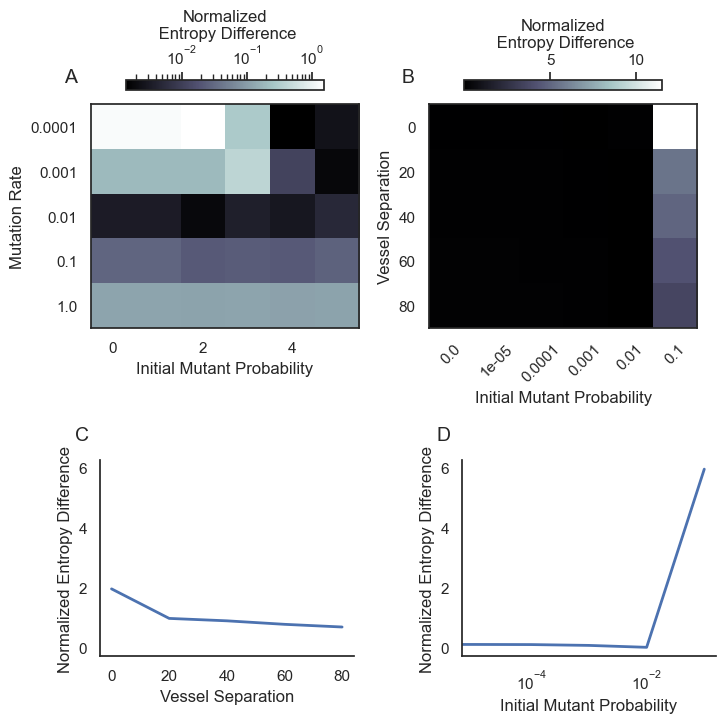

In [6]:
ent_map = np.zeros((len(vessel_sep),len(init_mutant)))

for key in entropy_res_dict.keys():
    vessel_indx = np.argwhere(np.array(vessel_sep) == key[0])[0]
    init_indx = np.argwhere(np.array(init_mutant) == key[1])[0]
    ent_map[vessel_indx,init_indx] = entropy_res_dict[key]
    # p_mat[mut_indx,init_indx] = entropy_res_dict[key]

fig,ax_list = plt.subplots(ncols=2,nrows=2,figsize=(8,8))

ax = ax_list[0,0]

norm = colors.LogNorm(vmin=entropy_map.min(), vmax=entropy_map.max())
im = ax.imshow(entropy_map,cmap='bone',norm=norm)

# ax.set_xticks(np.arange(len(init_mutant)))
# ax.set_xticklabels(init_mutant,rotation=45)
ax.set_yticks(np.arange(len(mutation_rates)))
# mutation_supply = np.array(mutation_rates)*10**4
ax.set_yticklabels(mutation_rates)
ax.set_xlabel('Initial Mutant Probability')
ax.set_ylabel('Mutation Rate')

# make colorbars
ax.set_aspect(1)
fig.colorbar(im,ax=ax,shrink=0.7,label='Normalized\n Entropy Difference',location='top')

ax = ax_list[0,1]
norm = colors.LogNorm(vmin=ent_map.min(), vmax=ent_map.max())
im = ax.imshow(ent_map,cmap='bone')
# im1 = ax_list[1].imshow(p_mat)
# for ax in ax_list:
ax.set_xticks(np.arange(len(init_mutant)))
ax.set_xticklabels(init_mutant,rotation=45)
ax.set_yticks(np.arange(len(vessel_sep)))
ax.set_yticklabels(vessel_sep)
# mutation_supply = np.array(mutation_rates)*10**4
# ax.set_yticklabels(mutation_supply)
ax.set_xlabel('Initial Mutant Probability')
ax.set_ylabel('Vessel Separation')
# ax.set_ylabel('Mutation Supply')

fig.colorbar(im,ax=ax,shrink=0.7,label='Normalized\n Entropy Difference',location='top')
# fig.colorbar(im1,ax=ax_list[1],shrink=0.7,label='normalized error',location='top')
# fig.colorbar(im1,ax=ax_list[1],shrink=0.5)

bv_diff = np.mean(ent_map,axis=1)
mut_prob_diff = np.mean(ent_map,axis=0)

ax = ax_list[1,0]
ax.plot(vessel_sep,bv_diff,linewidth=2)
# ax.set_yscale('log')
ax.set_ylabel('Normalized Entropy Difference',fontsize=12)
ax.set_xlabel('Vessel Separation')

ax = ax_list[1,1]
ax.plot(init_mutant,mut_prob_diff,linewidth=2)
ax.set_xscale('log')
# ax.set_yscale('log')
ax.set_ylabel('Normalized Entropy Difference',fontsize=12)
ax.set_xlabel('Initial Mutant Probability')

ymin = np.min([ax.get_ylim()[0] for ax in ax_list[1,:]])
ymax = np.max([ax.get_ylim()[1] for ax in ax_list[1,:]])

for ax in ax_list[1,:]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim([ymin,ymax])

# shrink lower axes by 10%
pos = ax_list[1,0].get_position() # get the original position
pos2 = [pos.x0, pos.y0, pos.width*0.9, pos.height*0.7]
ax_list[1,0].set_position(pos2) # set a new position

pos = ax_list[1,1].get_position() # get the original position
pos2 = [pos.x0, pos.y0, pos.width*0.9, pos.height*0.7]
ax_list[1,1].set_position(pos2) # set a new position

# # move lower axes right and up
pos1 = ax_list[1,0].get_position() # get the original position
pos2 = [pos1.x0 + 0.02, pos1.y0 + 0.01,  pos1.width, pos1.height]
ax_list[1,0].set_position(pos2) # set a new position

pos1 = ax_list[1,1].get_position() # get the original position
pos2 = [pos1.x0 + 0.05, pos1.y0 + 0.01,  pos1.width, pos1.height]
ax_list[1,1].set_position(pos2) # set a new position

# add labels
ax_list[0,0].text(-0.1,1.1,'A',transform=ax_list[0,0].transAxes,fontsize=14)
ax_list[0,1].text(-0.1,1.1,'B',transform=ax_list[0,1].transAxes,fontsize=14)
ax_list[1,0].text(-0.1,1.1,'C',transform=ax_list[1,0].transAxes,fontsize=14)
ax_list[1,1].text(-0.1,1.1,'D',transform=ax_list[1,1].transAxes,fontsize=14)

fig.savefig('figures/sensitivity_analysis.pdf',dpi=300)


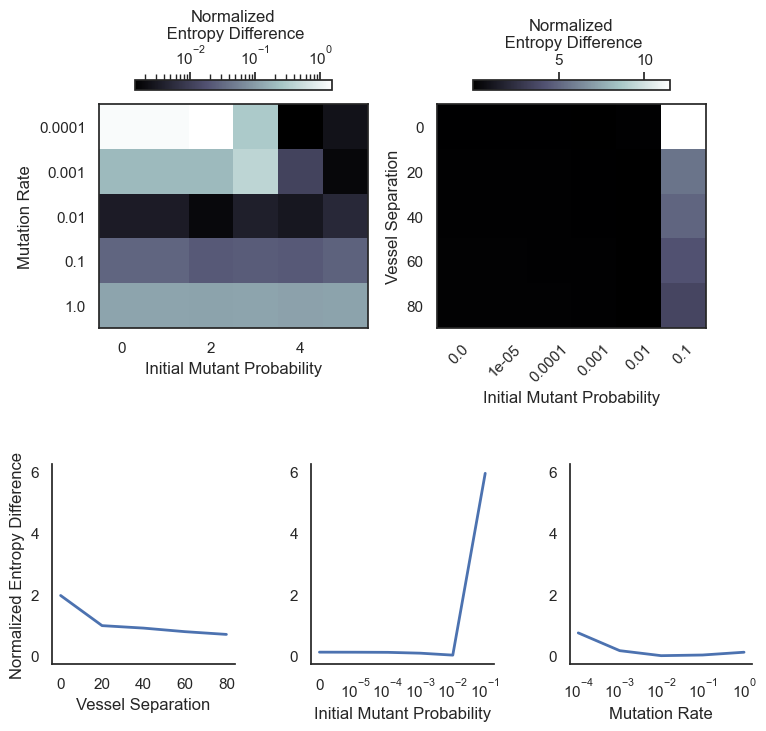

In [7]:
# make a plot using gridspec

fig = plt.figure(figsize=(8,8))

gs = fig.add_gridspec(2,1)

gs0 = gs[0].subgridspec(1,2)
gs1 = gs[1].subgridspec(1,3)

ax = fig.add_subplot(gs0[0])

norm = colors.LogNorm(vmin=entropy_map.min(), vmax=entropy_map.max())
im = ax.imshow(entropy_map,cmap='bone',norm=norm)

# ax.set_xticks(np.arange(len(init_mutant)))
# ax.set_xticklabels(init_mutant,rotation=45)
ax.set_yticks(np.arange(len(mutation_rates)))
# mutation_supply = np.array(mutation_rates)*10**4
ax.set_yticklabels(mutation_rates)
ax.set_xlabel('Initial Mutant Probability')
ax.set_ylabel('Mutation Rate')

# make colorbars
ax.set_aspect(1)
fig.colorbar(im,ax=ax,shrink=0.7,label='Normalized\n Entropy Difference',location='top')

ax = fig.add_subplot(gs0[1])

norm = colors.LogNorm(vmin=ent_map.min(), vmax=ent_map.max())
im = ax.imshow(ent_map,cmap='bone')
# im1 = ax_list[1].imshow(p_mat)
# for ax in ax_list:
ax.set_xticks(np.arange(len(init_mutant)))
ax.set_xticklabels(init_mutant,rotation=45)
ax.set_yticks(np.arange(len(vessel_sep)))
ax.set_yticklabels(vessel_sep)
# mutation_supply = np.array(mutation_rates)*10**4
# ax.set_yticklabels(mutation_supply)
ax.set_xlabel('Initial Mutant Probability')
ax.set_ylabel('Vessel Separation')
# ax.set_ylabel('Mutation Supply')

fig.colorbar(im,ax=ax,shrink=0.7,label='Normalized\n Entropy Difference',location='top')

lower_ax_list = []

ax = fig.add_subplot(gs1[0])

lower_ax_list.append(ax)

bv_diff = np.mean(ent_map,axis=1)
mut_prob_diff = np.mean(ent_map,axis=0)

ax.plot(vessel_sep,bv_diff,linewidth=2)
# ax.set_yscale('log')
ax.set_ylabel('Normalized Entropy Difference')
ax.set_xlabel('Vessel Separation')

# ax.set_aspect(300,adjustable='box')

pos = ax.get_position()
# shift down

# pos.y0 = pos.y0 - 0.06
# pos.y1 = pos.y1 - 0.06

ax.set_position(pos)

ax = fig.add_subplot(gs1[1])

lower_ax_list.append(ax)

ax.plot(init_mutant,mut_prob_diff,linewidth=2)
ax.set_xscale('symlog',linthresh=10**-5)
# ax.set_yscale('log')
# ax.set_ylabel('Normalized Entropy Difference')
ax.set_xlabel('Initial Mutant Probability')

# set the height to be the same as the other ax

pos = ax.get_position()
pos.y1 = lower_ax_list[0].get_position().y1
pos.y0 = lower_ax_list[0].get_position().y0

ax.set_position(pos)

ax = fig.add_subplot(gs1[2])

lower_ax_list.append(ax)

pos = ax.get_position()
pos.y1 = lower_ax_list[0].get_position().y1
pos.y0 = lower_ax_list[0].get_position().y0

mut_rate_marginal_dist = np.mean(entropy_map,axis=1)

ax.plot(mutation_rates,mut_rate_marginal_dist,linewidth=2)

ax.set_xscale('symlog',linthresh=10**-4)

ax.set_xlabel('Mutation Rate')
# ax.set_ylabel('Normalized Entropy Difference')

pos = ax.get_position()
pos.y1 = lower_ax_list[0].get_position().y1
pos.y0 = lower_ax_list[0].get_position().y0

ax.set_position(pos)

# move the left ax to the left

ax = lower_ax_list[0]
pos = ax.get_position()
pos.x0 = pos.x0 - 0.05
pos.x1 = pos.x1 - 0.05
ax.set_position(pos)

# move the right ax to the right

ax = lower_ax_list[2]
pos = ax.get_position()
pos.x0 = pos.x0 + 0.05
pos.x1 = pos.x1 + 0.05
ax.set_position(pos)

# set ymax and ymin the same

ymin = np.min([ax.get_ylim()[0] for ax in lower_ax_list])
ymax = np.max([ax.get_ylim()[1] for ax in lower_ax_list])

for ax in lower_ax_list:
    ax.set_ylim([ymin,ymax])



for ax in lower_ax_list:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    pos = ax.get_position()
    pos.y1 = pos.y1 - 0.1

    ax.set_position(pos)

lower_ax_list[0].set_xticks(vessel_sep);
# lower_ax_list[1].set_xticks(init_mutant);

In [8]:
# modelConfigDic = {'xDim':100,"yDim":100,'nTSteps':5000,"saveModelState":True,
#                     "imageFrequency":-1,"consumpRate":None,
#                     "nReplicates":1,"dt":0.1,"initialGeometry":"square","initialDensity":0.01,
#                     "saveFinalDiffImg":True,"saveFinalDiffGrid":True,"saveFinalPopGrid":True,
#                     "vesselSep":50,"mutProb":0.001,"pMutant":0.1}
jarFileName = "./HAL_dose_response.jar"
imgDir = "./tmp/"
today = date.today()
date_str = today.strftime("%Y-%m-%d")
data_folder = "./data/sensitivity_analysis_" + date_str

vessel_sep = [0,20,40,60,80]
modelConfigDic = {'xDim':100,"yDim":100,'nTSteps':10000,"saveModelState":True,
                "imageFrequency":-1,"consumpRate":0.01,
                "nReplicates":1,"dt":0.1,"initialGeometry":"circle","initialDensity":0.01,
                "saveFinalDiffImg":True,"saveFinalDiffGrid":True,"saveFinalPopGrid":True,
                "mutProb":0.001,"dieProb":0.1,"threeParamHill":True}

# consumpt_rate = 0.01
# modelConfigDic['consumpRate'] = consumpt_rate
for i,v_s in enumerate(vessel_sep):
    modelConfigDic['vesselSep'] = v_s
    
    # modelConfigDic['mutProb'] = r_m
    dataDir = data_folder + "/cellCountDoseResponse_vis_{}".format(i)
    # modelConfigDic['saveModelState'] = True
    myModel = DoseResponseModel(jarFileName = jarFileName, outDir=dataDir, imageOutDir=imgDir, **modelConfigDic)
    myModel.Simulate()    # 

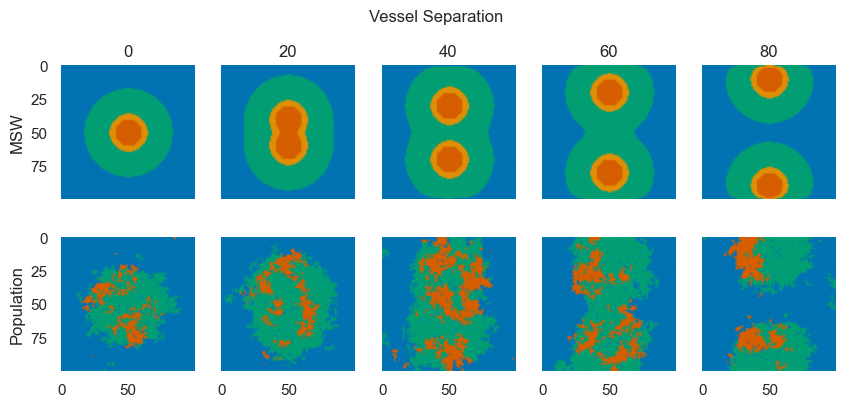

In [9]:
fig,ax = plt.subplots(ncols=len(vessel_sep),nrows=2,sharex=True,sharey=True,figsize=(10,5))

cmap = colors.ListedColormap(sns.color_palette("colorblind", as_cmap=True)[0:4])

for i,v_s in enumerate(vessel_sep):

    # load and plot MSW grid
    dataDir = data_folder + "/cellCountDoseResponse_vis_{}".format(i)
    diffGridFile = dataDir + '/RepId_0_diffGrid.csv'
    diffGrid = pd.read_csv(diffGridFile)
    img_t = np.zeros((100,100))
    for index,row in diffGrid.iterrows():
        if row['field'] > 0:
            img_t[int(row['x']),int(row['y'])] = row['field']
    img_t = get_most_fit_at_conc(img_t)

    ax[0,i].imshow(img_t,cmap=cmap,
              interpolation='gaussian',interpolation_stage='rgba')
    
    ax[0,i].set_title('{}'.format(v_s,fontsize=10))

    ax[0,i].spines['top'].set_visible(False)
    ax[0,i].spines['right'].set_visible(False)
    ax[0,i].spines['bottom'].set_visible(False)
    ax[0,i].spines['left'].set_visible(False)
    
    # load and plot pop grid
    popGridFile = dataDir + '/RepId_0_popGrid.csv'
    popGrid = pd.read_csv(popGridFile)
    img_t = np.zeros((100,100))
    for index,row in popGrid.iterrows():
        img_t[int(row['x']),int(row['y'])] = row['genotype']
    img_t = get_most_fit_at_conc(img_t)
    ax[1,i].imshow(img_t,cmap=cmap,
                interpolation='gaussian',interpolation_stage='rgba')
    
    ax[1,i].spines['top'].set_visible(False)
    ax[1,i].spines['right'].set_visible(False)
    ax[1,i].spines['bottom'].set_visible(False)
    ax[1,i].spines['left'].set_visible(False)

# shift bottom row up

ax[0,0].set_ylabel('MSW',fontsize=12)
ax[1,0].set_ylabel('Population',fontsize=12)

pos0 = ax[0,0].get_position() # get the original position
for i in range(len(vessel_sep)):
    pos1 = ax[1,i].get_position() # get the original position
    pos1.y1 = pos0.y0
    ax[1,i].set_position(pos1) # set a new position

fig.suptitle('Vessel Separation',fontsize=12,y=0.95)

fig.savefig('figures/example_vessel_sep.pdf',bbox_inches='tight')